# 1 Import Libraries and Packages 

In [1]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from datetime import datetime, timedelta, date
from prophet import Prophet
from neuralprophet import NeuralProphet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

Importing plotly failed. Interactive plots will not work.


In [2]:
user = os.getenv("USER")
date_column = "diagnosis_date"
label = "total_cases"

# 2 Import the dataset and check the columns

In [3]:
#Import the dataset

data = pd.read_csv(f"/Users/{user}/forecasting-part-two/victoria_transmission_source_data.csv", date_parser=True)

In [4]:
print(data.shape) #Getting the shape of the data
data.head()

(584, 6)


,Unnamed: 0,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation
0,26/01,1.0,0.0,0.0,0.0,0.0
1,27/01,0.0,0.0,0.0,0.0,0.0
2,28/01,0.0,0.0,0.0,0.0,0.0
3,29/01,1.0,0.0,0.0,0.0,0.0
4,30/01,0.0,0.0,0.0,0.0,0.0


In [5]:
data = data.rename(columns={"Unnamed: 0":date_column})
data[0:341][date_column] = [val + "/2020" for val in data[0:341][date_column]] #2020 data available from 26 Jan
data[341:][date_column] = [val + "/2021" for val in data[341:][date_column]]
data[date_column] = pd.to_datetime(data[date_column], format="%d/%m/%Y")

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/2631143039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[0:341][date_column] = [val + "/2020" for val in data[0:341][date_column]] #2020 data available from 26 Jan
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/2631143039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[341:][date_column] = [val + "/2021" for val in data[341:][date_column]]


In [6]:
#viccases dataframe
vic_cases = data[:-1].copy() #last row in the data has no values
vic_cases.set_index(date_column, inplace=True)
vic_cases[label] = vic_cases[vic_cases.columns].sum(axis=1)

vic_cases.index.asfreq = "d" #adding the frequency to daily

In [7]:
vic_cases

,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,total_cases
diagnosis_date,,,,,,
2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-08-26,0.0,72.0,6.0,0.0,1.0,79.0
2021-08-27,0.0,66.0,12.0,0.0,1.0,79.0
2021-08-28,0.0,52.0,0.0,0.0,12.0,64.0


# 3 Explore the data

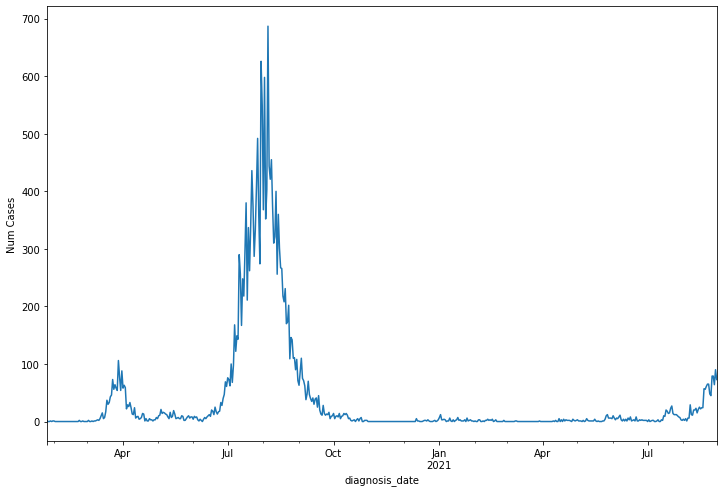

In [8]:
#Chaging the figsize
plt.rcParams["figure.figsize"] = (12,8)

#Lets the plot the data
vic_cases[label].plot()
plt.ylabel("Num Cases");

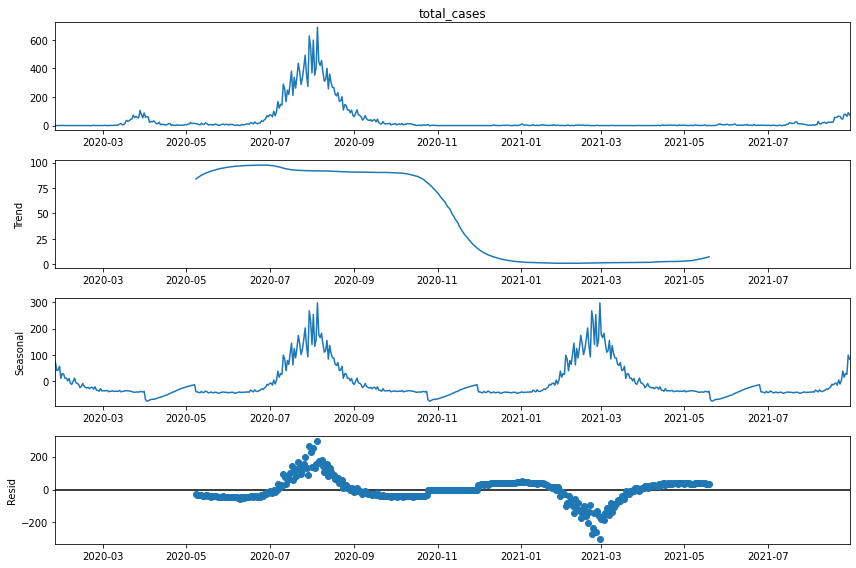

In [9]:
#Lets apply the Seasonal decomposition
results = seasonal_decompose(vic_cases[label], period=207)
results.plot();

# 4 Find the AR, MA, I values using plots and do some statistical tests

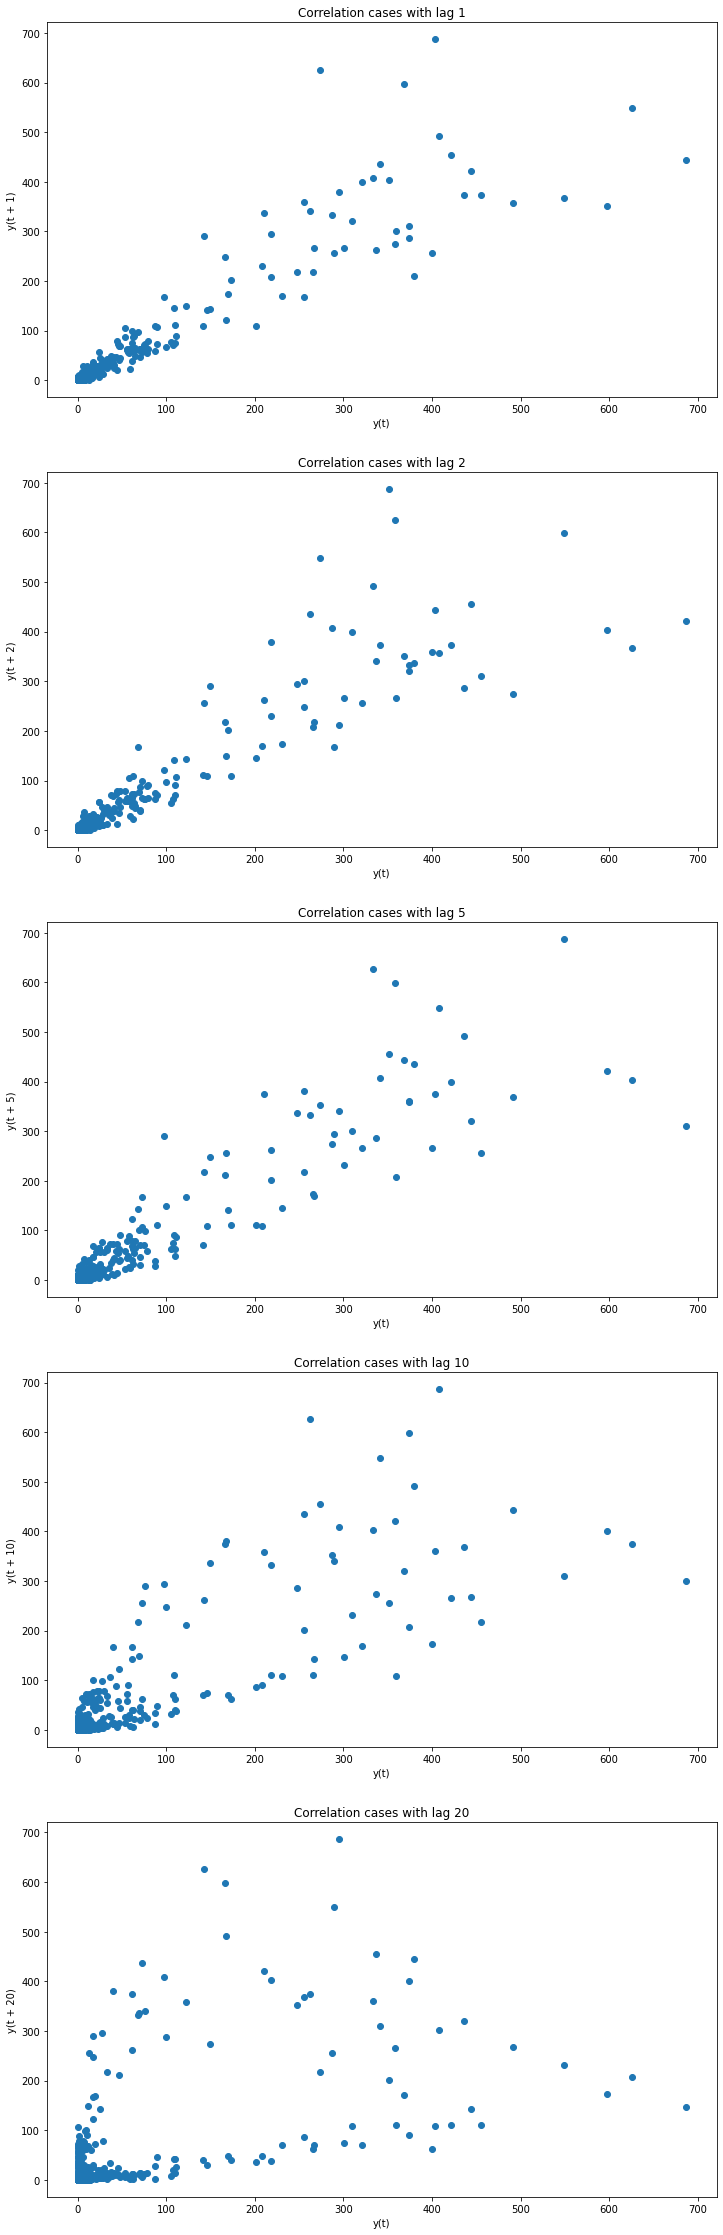

In [10]:
#Lets check if our lags are correlated
total_lags = [1, 2, 5, 10, 20]
fig, axes = plt.subplots(nrows=len(total_lags), ncols=1, figsize=(12,40))
index=0
for lg in total_lags:
    pd.plotting.lag_plot(vic_cases[label], lag=lg, ax=axes[index]);
    axes[index].set_title(f"Correlation cases with lag {lg}")
    index+=1

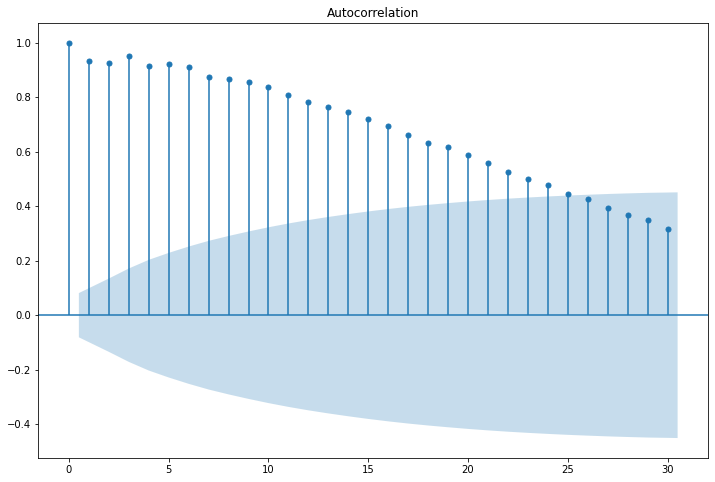

In [11]:
#Lets make it easier and use acf plot, and use this to get the value for AR side of the model
plot_acf(vic_cases[label],lags=30);

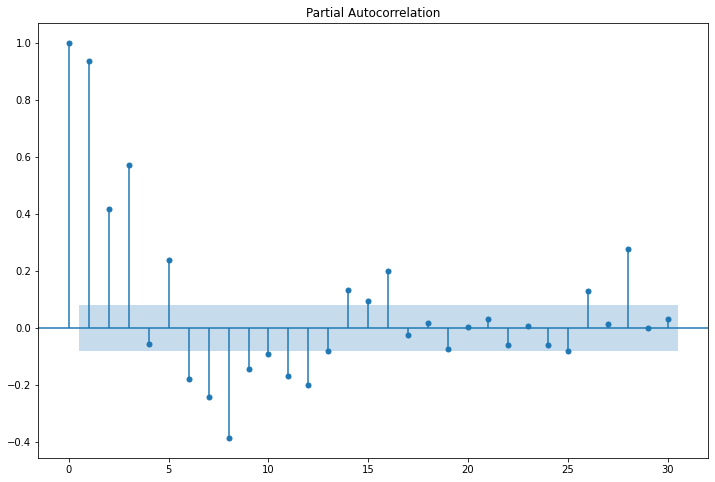

In [12]:
#Lets make it easier and use pacf plot, and use this to get the value for MA side of the model
plot_pacf(vic_cases['total_cases'],lags=30);

In [13]:
#Let check if data is stationary, if value is below 0.05, we can determine data is stationary
def adf_fuller_df(df, colname=""):
    """"The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
        root, which means there is a trend component, with the alternative that 
        there is no unit root, hence no trend component. If the pvalue is above 
        a critical size, then we cannot reject that there is a unit root."""

    df = df.copy()
    vals = adfuller(df[colname])
    first_columns = ["adf", "p-value", "usedlags", "number of observations"]
    other_column = "icbest"
    df = pd.DataFrame(data=pd.Series(vals[0:4], index=first_columns)).T
    for key, val in vals[4].items():
        df[f"Critical value for {key}"] = val
    df[other_column] = vals[5]
    p_value = df["p-value"][0]
    if  p_value <= 0.05:
        print(f"""We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only {np.round(p_value*100,2)} percent
        likelihood, that series is not stationary, and is very small""")
    else:
        print("We should further difference the series with itself ")
    
    return df

In [14]:
adf_fuller_df(vic_cases, label)

We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only 0.93 percent
        likelihood, that series is not stationary, and is very small


,adf,p-value,usedlags,number of observations,Critical value for 1%,Critical value for 5%,Critical value for 10%,icbest
0,-3.450894,0.009342,16.0,566.0,-3.441956,-2.86666,-2.569497,5134.020943


In [15]:
#Can we use auto arima instead to get all values of AR, I and MA
# Based on the plots, we could say AR can be max 21, MA could be max 3 and I is 0

# 5 Run auto arima to find out values for AR, MA and I side of the modes

In [16]:
auto_arima_model = auto_arima(vic_cases[label],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5428.542, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5783.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5667.801, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5565.954, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5781.142, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5528.265, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5444.785, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5430.447, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5382.154, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5385.354, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5351.161, Time=0.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5350.696, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5426.084, Time=0.46 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5333.428, Time=0.71 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  583
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2656.804
Date:                Tue, 31 Aug 2021   AIC                           5329.608
Time:                        08:50:00   BIC                           5364.539
Sample:                             0   HQIC                          5343.224
                                - 583                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4388      0.028     15.791      0.000       0.384       0.493
ar.L2         -0.3114      0.019    -16.289      0.000      -0.349      -0.274
ar.L3          0.4620      0.013     34.523      0.000       0.436       0.488
ar.L4         -0.2142      0.018    -11.905      0.000      -0.249      -0.179
ar.L5          0.4096      0.012     33.421      0.000       0.386       0.434
ma.L1         -1.1607      0.031    -37.056      0.000      -1.222      -1.099
ma.L2          0.4026      0.028     14.511      0.000       0.348       0.457
sigma2       538.0944      8.673     62.039      0.000     521.095     555.094
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23198.21
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 6 Lets split the data into training and Test

In [17]:
#Lets split the data into train and testing
train = vic_cases[:"2021-08-25"]
test = vic_cases["2021-08-26":]

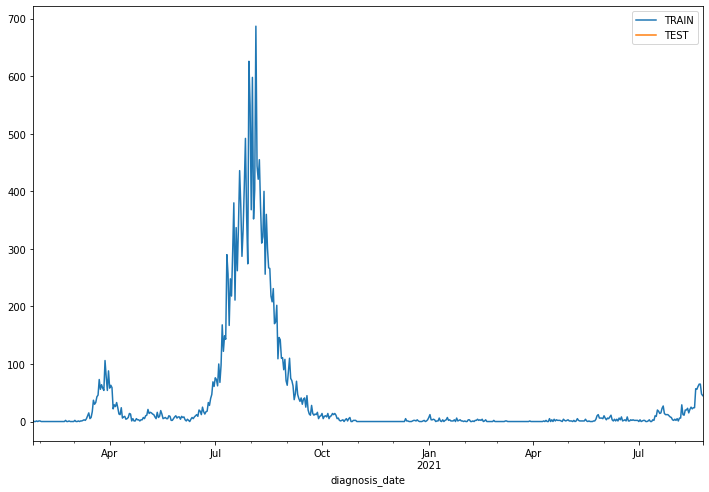

In [18]:
ax = train[label].plot()
ax.plot(test[label])
ax.legend(["TRAIN", "TEST"]);

In [19]:
auto_arima_model = auto_arima(train[label],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5385.238, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5736.530, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5622.209, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5521.258, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5734.533, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5483.902, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5401.303, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5387.140, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5339.277, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5342.120, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5309.616, Time=0.60 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5309.222, Time=0.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5383.024, Time=0.47 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5291.890, Time=0.70 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  578
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2636.003
Date:                Tue, 31 Aug 2021   AIC                           5288.006
Time:                        08:50:10   BIC                           5322.868
Sample:                             0   HQIC                          5301.601
                                - 578                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4350      0.028     15.577      0.000       0.380       0.490
ar.L2         -0.3128      0.019    -16.184      0.000      -0.351      -0.275
ar.L3          0.4603      0.014     34.087      0.000       0.434       0.487
ar.L4         -0.2124      0.018    -11.746      0.000      -0.248      -0.177
ar.L5          0.4099      0.012     33.298      0.000       0.386       0.434
ma.L1         -1.1563      0.031    -36.710      0.000      -1.218      -1.095
ma.L2          0.4010      0.028     14.388      0.000       0.346       0.456
sigma2       541.8806      8.801     61.571      0.000     524.631     559.130
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22803.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 7 Train the model based on ARIMA terms from Auto arima

In [20]:
#train the data based on the parameters we got
arima_model = ARIMA(train[label], order=(5,1,2)).fit()
arima_model.summary()

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationa

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  578
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2636.003
Date:                Tue, 31 Aug 2021   AIC                           5288.006
Time:                        08:50:10   BIC                           5322.868
Sample:                    01-26-2020   HQIC                          5301.601
                         - 08-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4350      0.028     15.577      0.000       0.380       0.490
ar.L2         -0.3128      0.019    -16.184      0.000      -0.351      -0.275
ar.L3          0.4603      0.014     34.087      0.000       0.434       0.487
ar.L4         -0.2124      0.018    -11.746      0.000      -0.248      -0.177
ar.L5          0.4099      0.012     33.298      0.000       0.386       0.434
ma.L1         -1.1563      0.031    -36.710      0.000      -1.218      -1.095
ma.L2          0.4010      0.028     14.388      0.000       0.346       0.456
sigma2       541.8806      8.801     61.571      0.000     524.631     559.130
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22803.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 8 Make predictions

In [21]:
#Predict the model
start = train.shape[0] 
end = train.shape[0] + test.shape[0] - 1
arima_predictions = arima_model.predict(start=start, end=end)

In [22]:
results=test
test["predictions"] = [p for p in arima_predictions]

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/4087890050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = [p for p in arima_predictions]


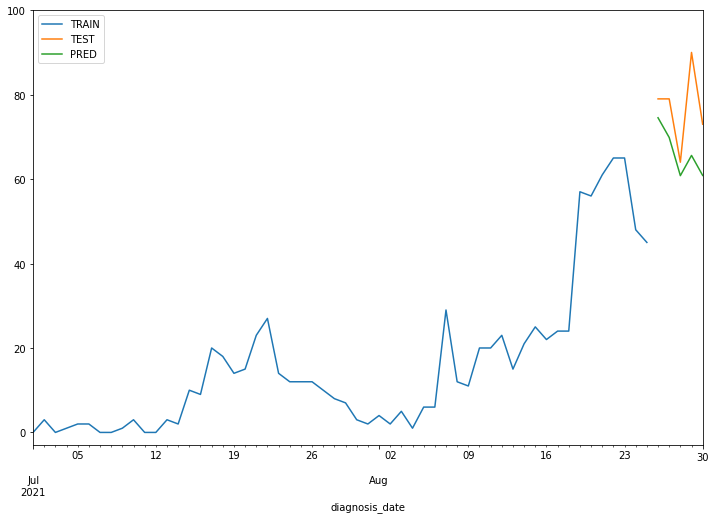

In [23]:
#plotting the results
ax = train[label].plot()
ax.plot(test[label])
ax.plot(test["predictions"])
ax.set_xlim(date(2021,7,1),date(2021,8,30))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED"]);

# 9 Evaluate the model

In [24]:
#measure performance
RMSE=rmse(results[label], results.predictions)
MSE=mse(results[label], results.predictions)

print(f"rmse is {RMSE}")
print(f"mse is {MSE}")
print("mean is {}".format(test[label].mean()))
print("std is {}".format(test[label].std()))

rmse is 13.084909754821465
mse is 171.21486329182193
mean is 77.0
std is 9.513148795220223


# 10 Lets try model building training, testing with Fb Prophet Library

In [25]:
#The library like dates in DS column and target variable in Y
vic_cases = vic_cases.reset_index()
vic_cases = vic_cases.rename(columns={label:"y", date_column:"ds"})
vic_cases.head()

,ds,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,y
0,2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#splitting data into training and testing
trainX=vic_cases[:-test.shape[0]][["ds","y"]]
textX=vic_cases[-test.shape[0]:][["ds","y"]]

In [27]:
#Train the model

#Define the model
fb_model=Prophet()

#Fit the model
fb_model.fit(trainX)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.15007
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       940.929    0.00540393       102.415   6.272e-05       0.001      125  LS failed, Hessian reset 
      99       942.409     0.0294607       73.8954           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       942.812    0.00124452       100.012   1.821e-05       0.001      197  LS failed, Hessian reset 
     131       943.438   0.000550585        81.211   1.061e-05       0.001      281  LS failed, Hessian reset 
     199       945.127      0.201492       336.964           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       947.875    0.00817405       87.8904   9.133e-05       0.001      417  LS failed, Hessian reset 
     233        948.59   0.000184337       61.8529   3.173e-06   

In [28]:
#future dates
future = fb_model.make_future_dataframe(periods=test.shape[0])
future.tail(test.shape[0])

,ds
578,2021-08-26
579,2021-08-27
580,2021-08-28
581,2021-08-29
582,2021-08-30


In [29]:
#forecast
fb_predictions=fb_model.predict(future)
fb_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])


,ds,yhat,yhat_lower,yhat_upper
578,2021-08-26,9.815230,-79.008502,94.639042
579,2021-08-27,8.055306,-88.734314,97.201588
580,2021-08-28,7.264974,-87.482166,101.800416
581,2021-08-29,10.313654,-78.891499,95.619302
582,2021-08-30,3.866664,-85.932512,91.744086


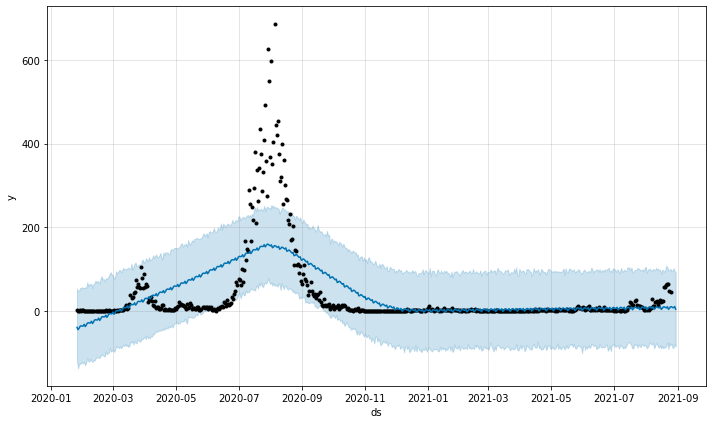

In [30]:
#plot the data
fig1 = fb_model.plot(fb_predictions)


In [31]:
train[label] = train[label].astype(float)
test[label] = test[label].astype(float)

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/4049480995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[label] = train[label].astype(float)
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/4049480995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[label] = test[label].astype(float)


In [32]:
ets_model = ets.ETSModel(train[label], freq='D', error='add').fit()
predictions_ets = ets_model.predict(start=start, end=end)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20046D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.96662D+00    |proj g|=  4.27603D-01

At iterate    2    f=  4.82365D+00    |proj g|=  3.22975D-01

At iterate    3    f=  4.77810D+00    |proj g|=  1.82596D-02

At iterate    4    f=  4.77804D+00    |proj g|=  8.65974D-05

At iterate    5    f=  4.77804D+00    |proj g|=  2.22045D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      7     0     0   

In [33]:
fb_pred = fb_predictions[["ds","yhat"]][-test.shape[0]:]
fb_pred.set_index("ds", inplace=True)

In [34]:
fb_pred

,yhat
ds,
2021-08-26,9.815230
2021-08-27,8.055306
2021-08-28,7.264974
2021-08-29,10.313654
2021-08-30,3.866664


# 11 Create ensemble of three models and visualise the results

In [35]:
#Ensemble predictions
ensemble = (fb_pred.yhat + predictions_ets + test.predictions)/3

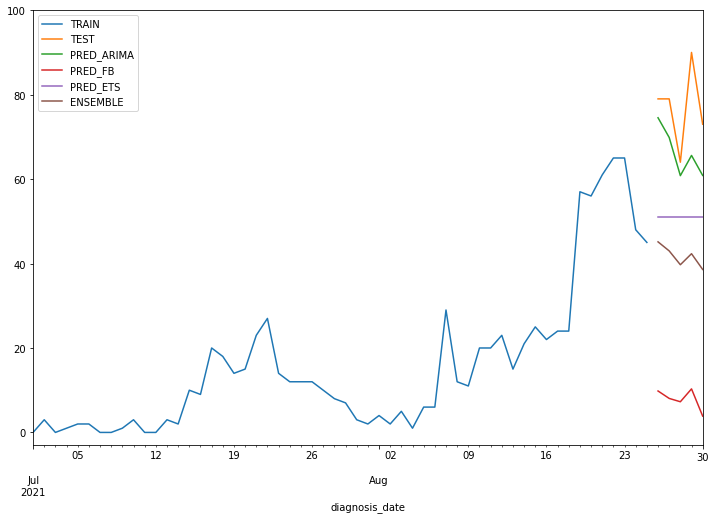

In [36]:
ax = train[label].plot()
ax.plot(test[label])
ax.plot(test["predictions"])
ax.plot(fb_pred['yhat'])
ax.plot(predictions_ets)
ax.plot(ensemble)
ax.set_xlim(date(2021,7,1),date(2021,8,30))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA","PRED_FB", "PRED_ETS","ENSEMBLE"]);

# 12 Add some exogenous variables to the model and try make better predictions

In [37]:
data.head()

,diagnosis_date,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation
0,2020-01-26,1.0,0.0,0.0,0.0,0.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,1.0,0.0,0.0,0.0,0.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0


In [38]:
#Adding some features
vic_cases_wf = data[[date_column, "Overseas","Known Local","Unknown Local (Community)", "Interstate (N/A)", "Under Investigation"]][:-1]
#Formatting the index
vic_cases_wf.set_index(date_column, inplace=True)
vic_cases_wf[label] = vic_cases_wf[vic_cases_wf.columns].sum(axis=1)
vic_cases_wf["Unknown Local (Community)"] = vic_cases_wf[["Unknown Local (Community)", "Under Investigation"]].sum(axis=1)
vic_cases_wf["Community"] = vic_cases_wf[["Unknown Local (Community)","Known Local"]].sum(axis=1)
vic_cases_wf["lockdown"] = vic_cases_wf["Community"].apply(lambda val: 1 if val >= 10 else 0)

#Adding the delta feature
vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )

#print the shape
print(vic_cases_wf.shape)

vic_cases_wf.head()

(583, 9)


/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/3017244564.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )


,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,total_cases,Community,lockdown,delta
diagnosis_date,,,,,,,,,
2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


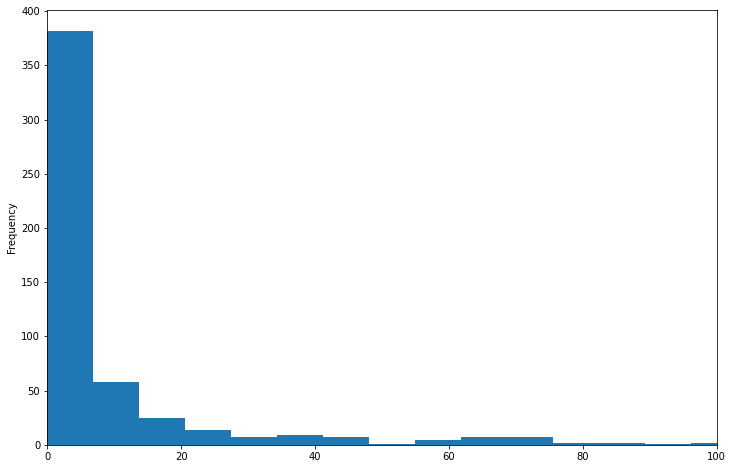

In [39]:
#Lets visualise number of common cases
vic_cases_wf["Community"].plot.hist(bins=100)
plt.xlim(0,100);

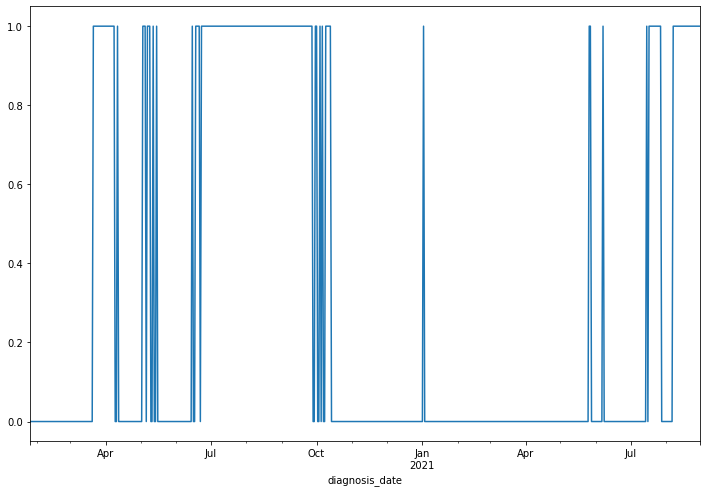

In [40]:
#Plotting the lockdown
vic_cases_wf.lockdown.plot();

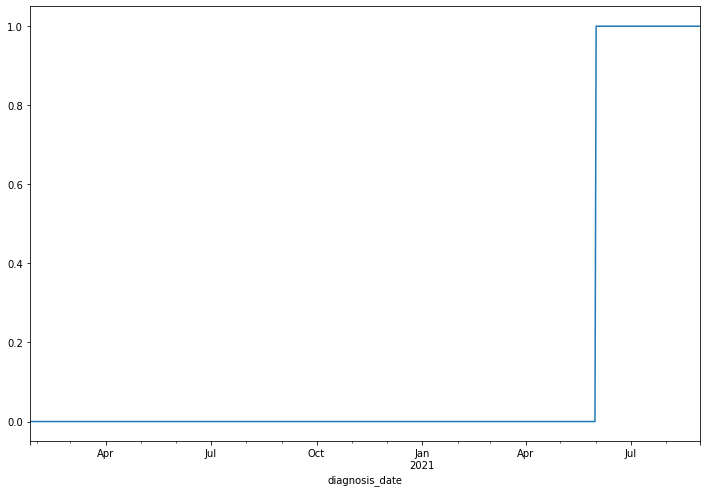

In [41]:
#Plotting delta
vic_cases_wf.delta.plot();

In [42]:
#features to include in the model
features = ["delta","lockdown","Unknown Local (Community)"]

In [43]:
#Subsetting the data
vic_cases_wf_final = vic_cases_wf[features + [label]]
vic_cases_wf_final = vic_cases_wf_final.rename(columns={label:"y"})
vic_cases_wf_final.index.rename("ds", inplace=True)
vic_cases_wf_final.head()

,delta,lockdown,Unknown Local (Community),y
ds,,,,
2020-01-26,0,0,0.0,1.0
2020-01-27,0,0,0.0,0.0
2020-01-28,0,0,0.0,0.0
2020-01-29,0,0,0.0,1.0
2020-01-30,0,0,0.0,0.0


In [44]:
#Lets split the data into train and testing
train = vic_cases_wf_final[:"2021-08-25"]
test = vic_cases_wf_final["2021-08-26":]

In [45]:
model = MinMaxScaler()
model.fit(train[["Unknown Local (Community)"]])
train["Unknown Local (Community)"] = model.transform(train[["Unknown Local (Community)"]])
test["Unknown Local (Community)"] = model.transform(test[["Unknown Local (Community)"]])

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/3985348790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Unknown Local (Community)"] = model.transform(train[["Unknown Local (Community)"]])
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_12237/3985348790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Unknown Local (Community)"] = model.transform(test[["Unknown Local (Community)"]])


In [46]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=True, 
                               random_state=42, #seed
                               n_fits=10,
                               m=7,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4988.203, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5415.733, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5042.384, Time=0.69 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5205.929, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5414.672, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4979.648, Time=1.08 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4980.305, Time=1.79 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=4981.699, Time=1.89 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=4973.163, Time=0.85 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=4910.728, Time=0.62 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=4928.668, Time=0.91 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=4992.517, Time=1.06 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  578
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -2440.989
Date:                                Tue, 31 Aug 2021   AIC                           4899.979
Time:                                        08:50:49   BIC                           4939.215
Sample:                                    01-26-2020   HQIC                          4915.278
                                         - 08-25-2021                                         
Covariance Type:                                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.2251      0.450      0.501      0.617      -0.656       1.106
delta                         1.7300     60.084      0.029      0.977    -116.033     119.493
lockdown                      6.7365      6.599      1.021      0.307      -6.198      19.670
Unknown Local (Community)   493.1147      4.980     99.016      0.000     483.354     502.876
ar.L1                         0.9802      0.005    184.108      0.000       0.970       0.991
ma.L1                        -0.5736      0.014    -39.627      0.000      -0.602      -0.545
ma.S.L7                      -0.1074      0.021     -5.039      0.000      -0.149      -0.066
ma.S.L14                     -0.1092      0.020     -5.427      0.000      -0.149      -0.070
sigma2                      270.2099      5.111     52.865      0.000     260.192     280.228
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19969.65
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             2.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5414.672, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5049.881, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5232.295, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4987.318, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4874.543, Time=0.51 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4875.866, Time=0.59 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4881.089, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4917.608, Time=0.52 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 5.310 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  578
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2430.271
Date:                Tue, 31 Aug 2021   AIC                           4874.543
Time:                        08:50:54   BIC                           4905.060
Sample:                    01-26-2020   HQIC                          4886.442
                         - 08-25-2021                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
delta                        12.0173     21.725      0.553      0.580     -30.564      54.598
lockdown                      6.1021      6.118      0.997      0.319      -5.889      18.093
Unknown Local (Community)   443.0908      6.274     70.619      0.000     430.793     455.388
ar.L1                         0.4523      0.012     39.306      0.000       0.430       0.475
ar.L2                         0.0561      0.015      3.780      0.000       0.027       0.085
ar.L3                         0.4487      0.012     38.563      0.000       0.426       0.471
sigma2                      260.9322      4.984     52.356      0.000     251.164     270.700
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):             14311.94
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#Train the models
sarmia_model_exog=SARIMAX(train["y"], exog=train[features],order=(1,0,1), seasonal_order=(0,0,2,7), freq="D", max_iter=200).fit()
arima_model_exog=ARIMA(train["y"], exog=train[features], order=(3,0,0)).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38414D+00    |proj g|=  2.54525D-01


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  4.32446D+00    |proj g|=  6.83736D-03

At iterate   10    f=  4.32238D+00    |proj g|=  2.50694D-03

At iterate   15    f=  4.31826D+00    |proj g|=  5.58151D-02

At iterate   20    f=  4.30182D+00    |proj g|=  1.88128D-03

At iterate   25    f=  4.30113D+00    |proj g|=  5.93204D-03

At iterate   30    f=  4.30035D+00    |proj g|=  4.86904D-03

At iterate   35    f=  4.23419D+00    |proj g|=  3.22658D-02

At iterate   40    f=  4.23092D+00    |proj g|=  1.79235D-04

At iterate   45    f=  4.23092D+00    |proj g|=  7.75955D-05

At iterate   50    f=  4.23085D+00    |proj g|=  3.81578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency info

In [49]:
sarima_exog_pred=sarmia_model_exog.predict(start=start, end=end, exog=test[features])
arima_exog_pred=arima_model_exog.predict(start=start, end=end, exog=test[features])

# 13 Visualise the predictions against actual data after retraining with variables

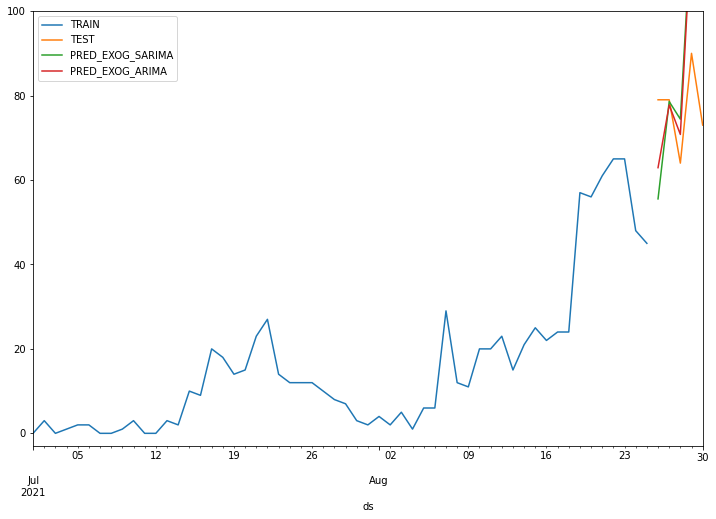

In [50]:
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(sarima_exog_pred)
ax.plot(arima_exog_pred)
ax.set_xlim(date(2021,7,1),date(2021,8,30))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_EXOG_SARIMA","PRED_EXOG_ARIMA"]);

# 14 Adding variables to FB model and predicting in the future

In [51]:
#Prepare training and testing data for FB prophet
train = train.reset_index()
test = test.reset_index()
fb_train = train[["ds","y"] + features]
fb_test = test[["ds","y"] + features]

In [52]:
#Traing fb with exog variables
fb_model_exog = Prophet()
for _ in features:
    fb_model_exog.add_regressor(_)
fb_model_exog.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.15007


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1612.95    0.00129241       124.959      0.4233      0.4233      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1616.02    0.00119304       99.6723           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1619.11     0.0260356       181.942           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1621.11   4.05082e-06       54.5254      0.4923      0.4923      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       1621.11   1.10219e-07       59.9476      0.3693           1      543   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

In [53]:
#Lets make predictions for the model
fb_exog_future = fb_model_exog.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast = fb_model_exog.predict(fb_exog_future)
#forecast
fb_exog_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

,ds,yhat,yhat_lower,yhat_upper
578,2021-08-26,53.274585,23.955870,81.632760
579,2021-08-27,81.287305,47.146002,111.299883
580,2021-08-28,73.052468,41.998867,104.377295
581,2021-08-29,136.626459,106.904001,168.021252
582,2021-08-30,130.788961,100.302369,158.481090


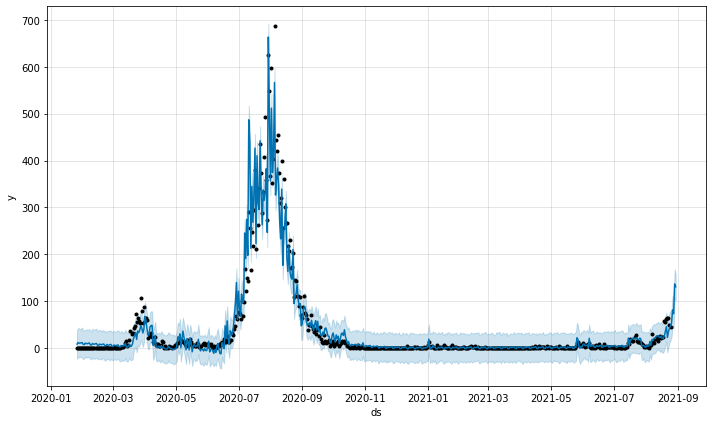

In [54]:
#plot the data
fig1 = fb_model_exog.plot(fb_exog_forecast)

In [55]:
#Ensemble predictions
fb_exog_pred = fb_exog_forecast[["ds","yhat"]][-test.shape[0]:]
fb_exog_pred.set_index("ds", inplace=True)
ensemble_exog = (fb_exog_pred.yhat + sarima_exog_pred + arima_exog_pred)/3
train.set_index("ds", inplace=True)
test.set_index("ds", inplace=True)

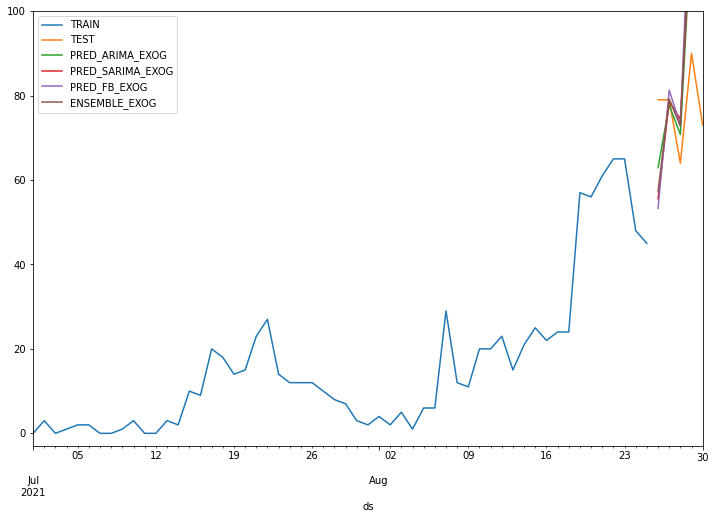

In [56]:
#Plotting all the models
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(arima_exog_pred)
ax.plot(sarima_exog_pred)
ax.plot(fb_exog_pred)
ax.plot(ensemble_exog)
ax.set_xlim(date(2021,7,1),date(2021,8,30))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA_EXOG","PRED_SARIMA_EXOG", "PRED_FB_EXOG","ENSEMBLE_EXOG"]);

# 15 Looking for seasonal component in model

In [57]:
#is there a seasonal component?
#Traing fb with exog variables
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.15007


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1610.83    0.00226414       292.445           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1614.63     0.0111457       205.334           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1615.59   9.86372e-05        111.95   3.771e-07       0.001      336  LS failed, Hessian reset 
     299       1616.45    0.00180881       125.039           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1617.57    0.00110983       82.6361           1           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1618.68     0.0082517       231.548           1           1      6

In [58]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

50   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     518       1619.64   0.000124197       167.782   1.287e-06       0.001      709  LS failed, Hessian reset 
     599       1620.31   0.000130704       62.8277      0.4855      0.4855      810   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1620.66   2.49584e-05       61.4002           1           1      933   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1620.79    0.00020839        77.311       2.052      0.5892     1065   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     802       1620.79   3.13347e-05       67.5989   4.691e-07       0.001     1101  LS failed, Hessian reset 
     873        1620.8   1.00732e-07        70.246      0.2392      0.9018     1199   
Optimization terminated normally: 
  Convergence detecte

,ds,yhat,yhat_lower,yhat_upper
578,2021-08-26,53.274585,24.226857,82.013320
579,2021-08-27,81.287305,50.516818,112.448214
580,2021-08-28,73.052468,43.508345,103.294213
581,2021-08-29,136.626459,108.159184,166.030538
582,2021-08-30,130.788961,98.256547,160.974825


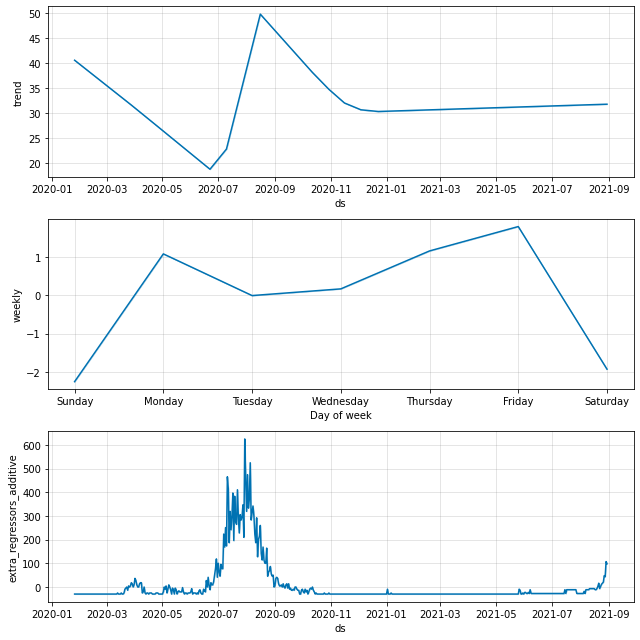

In [59]:
fb_model_exog_s.plot_components(fb_exog_forecast_s);

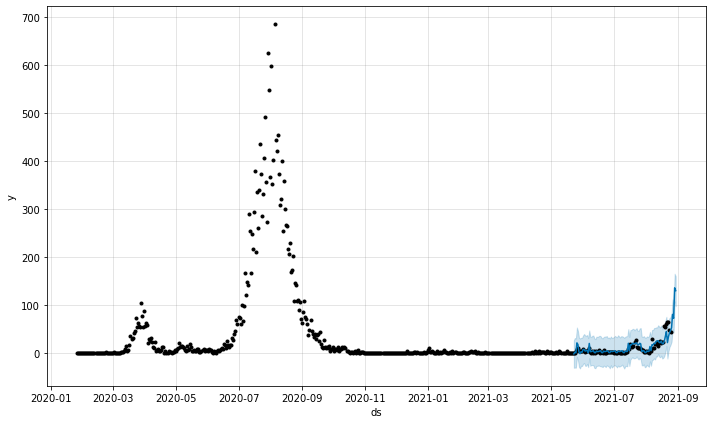

In [60]:
fb_model_exog_s.plot(fb_exog_forecast_s[-100:]);

In [61]:
fb_exog_forecast_s.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast_s["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 35.39086509268947


In [62]:
fb_exog_forecast.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 35.39086509268947


In [63]:
RMSE = rmse(test["y"], arima_exog_pred)
print(f"RMSE in arima exog model is {RMSE}")

RMSE in arima exog model is 23.83863593991423


In [64]:
RMSE = rmse(test["y"], sarima_exog_pred)
print(f"RMSE in sarima exog model is {RMSE}")

RMSE in sarima exog model is 26.199849034028304


In [65]:
RMSE = rmse(test["y"], ensemble_exog)
print(f"RMSE in sarima exog model is {RMSE}")

RMSE in sarima exog model is 28.424124998098137


# 16 Lets forecast in the unknown future

In [66]:
model = MinMaxScaler()
model.fit(vic_cases_wf_final[["Unknown Local (Community)"]])
vic_cases_wf_final["Unknown Local (Community)"] = model.transform(vic_cases_wf_final[["Unknown Local (Community)"]])

In [67]:
#Lets do a forecast finally
arima_model_exog=ARIMA(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(3,0,0)).fit()
sarima_model_exog=SARIMAX(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(1,0,1), seasonal_order=(0,0,2,7)).fit()
fb_full = pd.concat([fb_train, fb_test], axis=0, ignore_index=True)
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_full)

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38828D+00    |proj g|=  2.48287D-01

At iterate    5    f=  4.33117D+00    |proj g|=  7.47048D-03

At iterate   10    f=  4.32904D+00    |proj g|=  2.80826D-03

At iterate   15    f=  4.32379D+00    |proj g|=  5.35171D-02

At iterate   20    f=  4.30778D+00    |proj g|=  1.01074D-03

At iterate   25    f=  4.30684D+00    |proj g|=  1.43521D-02

At iterate   30    f=  4.27489D+00    |proj g|=  7.21080D-02

At iterate   35    f=  4.23492D+00    |proj g|=  5.21238D-03

At iterate   40    f=  4.23468D+00    |proj g|=  1.44782D-04

At iterate   45    f=  4.23468D+00    |proj g|=  8.32860D-05

At iterate   50    f=  4.23466D+00    |proj g|=  2.02018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.37704


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1622.73     0.0083308       243.745       1.348      0.1348      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       1624.78   9.31023e-05       82.3809   3.424e-07       0.001      213  LS failed, Hessian reset 
     199        1625.7   0.000587613       223.417           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       1625.83   0.000306936       190.334    4.24e-06       0.001      320  LS failed, Hessian reset 
     299       1627.18    0.00192257       179.741           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1627.63   0.000126278       55.7521           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha

In [68]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    if _ != "Unknown Local (Community)":
        fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]] + list(np.ones(test.shape[0]))
    else:
        fb_exog_future_s["Unknown Local (Community)"] = vic_cases_wf_final[-1:]["Unknown Local (Community)"].values[0]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

      alpha0  # evals  Notes 
     433       1628.68   0.000220438       268.333   1.708e-06       0.001      652  LS failed, Hessian reset 
     499       1630.07   0.000610348       89.5406           1           1      728   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     558       1630.35   7.49353e-06       66.3577   1.146e-07       0.001      834  LS failed, Hessian reset 
     599       1630.36   2.20338e-05        55.691       0.825       0.825      883   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     638       1630.37   1.91706e-05       72.3486   2.267e-07       0.001      977  LS failed, Hessian reset 
     699       1630.37    0.00013765       71.5076           1           1     1051   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     726       1630.38   1.97749e-07       74.3697      0.2652           1     1083   
Optimization 

,ds,yhat,yhat_lower,yhat_upper
583,2021-08-31,129.736525,101.654290,158.850806
584,2021-09-01,129.909048,101.081566,158.871807
585,2021-09-02,130.912195,100.265281,161.300377
586,2021-09-03,131.537862,102.276509,160.550281
587,2021-09-04,127.867534,96.809034,157.765462


In [69]:
#Foreasting arima and sarima
arima_exog_future=fb_exog_forecast_s[["ds"]][-test.shape[0]:]

#Adding exogenous variables
for _ in features:
    if _ != "Unknown Local (Community)":
        arima_exog_future[_] = 1
    else:
        arima_exog_future[_] = vic_cases_wf_final[-1:]["Unknown Local (Community)"].values[0]
arima_exog_future.set_index("ds", inplace=True)
start=vic_cases_wf_final.shape[0]
end=vic_cases_wf_final.shape[0] + test.shape[0] -1

#Forecasts
arima_exog_forecast = arima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])
sarima_exog_forecast = sarima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])

In [70]:
#extracting fb porphet forecast and adding the ensemble model
fb_exog_forecast_s = fb_exog_forecast_s[["ds","yhat"]][-test.shape[0]:]
fb_exog_forecast_s.set_index("ds", inplace=True)
ensemble_exog_forecast = (fb_exog_forecast_s.yhat + sarima_exog_forecast + arima_exog_forecast)/3

# 17 Making predictions with our four models

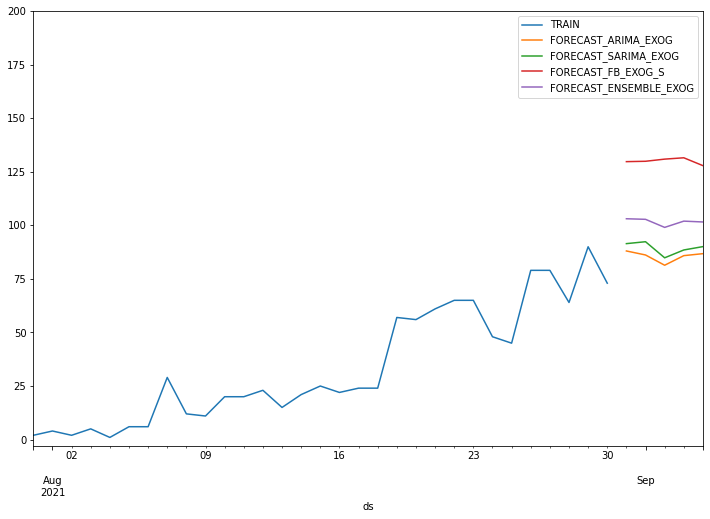

In [71]:
#Plotting all the models in uknown future
ax = vic_cases_wf_final["y"].plot()
ax.plot(arima_exog_forecast)
ax.plot(sarima_exog_forecast)
ax.plot(fb_exog_forecast_s)
ax.plot(ensemble_exog_forecast)
ax.set_xlim(date(2021,7,31),date(2021,9,4))
ax.set_ylim(-3,200)
ax.legend(["TRAIN", "FORECAST_ARIMA_EXOG","FORECAST_SARIMA_EXOG", "FORECAST_FB_EXOG_S", "FORECAST_ENSEMBLE_EXOG"]);

In [72]:
print(sarima_exog_forecast)

2021-08-31    91.463324
2021-09-01    92.357512
2021-09-02    84.847608
2021-09-03    88.502372
2021-09-04    90.074766
Freq: D, Name: predicted_mean, dtype: float64


In [73]:
print(arima_exog_forecast)

2021-08-31    88.040368
2021-09-01    86.169505
2021-09-02    81.377483
2021-09-03    85.857914
2021-09-04    86.784718
Freq: D, Name: predicted_mean, dtype: float64


In [74]:
print(ensemble_exog_forecast)

ds
2021-08-31    103.080073
2021-09-01    102.812022
2021-09-02     99.045762
2021-09-03    101.966049
2021-09-04    101.575673
dtype: float64


In [75]:
print(fb_exog_forecast_s)

                  yhat
ds                    
2021-08-31  129.736525
2021-09-01  129.909048
2021-09-02  130.912195
2021-09-03  131.537862
2021-09-04  127.867534


# 18 Lets try advanced model called neural prophet that uses AR-NET or neural networks for timeseries, another tool developed by facebook and uses pytorch as the backend

In [76]:
%%time
fb_neural_model = NeuralProphet(epochs=1000, n_forecasts=5, n_lags=3)
for _ in features:
    fb_neural_model.add_lagged_regressor(_)
fb_neural_metrics = fb_neural_model.fit(fb_full, freq='D')

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [01:56<00:00,  8.56it/s, SmoothL1Loss=0.0244

CPU times: user 1min 55s, sys: 1.09 s, total: 1min 57s
Wall time: 1min 57s


In [77]:
#Lets make predictions for the model
fb_neural_future = fb_neural_model.make_future_dataframe(df=fb_full, periods=test.shape[0])
for _ in features:
    if _ != "Unknown Local (Community)":
        fb_neural_future[_].iloc[-test.shape[0]:] = list(np.ones(test.shape[0]))
    else:
        fb_neural_future["Unknown Local (Community)"] = fb_full[-1:]["Unknown Local (Community)"].values[0]
    
fb_neural_forecast = fb_neural_model.predict(fb_neural_future)
fb_neural_forecast.head()


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_lockdown3,lagged_regressor_lockdown4,lagged_regressor_lockdown5,lagged_regressor_Unknown Local (Community)1,lagged_regressor_Unknown Local (Community)2,lagged_regressor_Unknown Local (Community)3,lagged_regressor_Unknown Local (Community)4,lagged_regressor_Unknown Local (Community)5,trend,season_weekly
0,2021-08-28,64.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2021-08-29,90.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2021-08-30,73.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2021-08-31,NaN,54.209999,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,5.644291,None,None,None,None,-1.568007,-2.373503
4,2021-09-01,NaN,None,NaN,64.386086,NaN,None,NaN,None,NaN,...,None,None,None,None,6.809061,None,None,None,-1.513239,1.040625


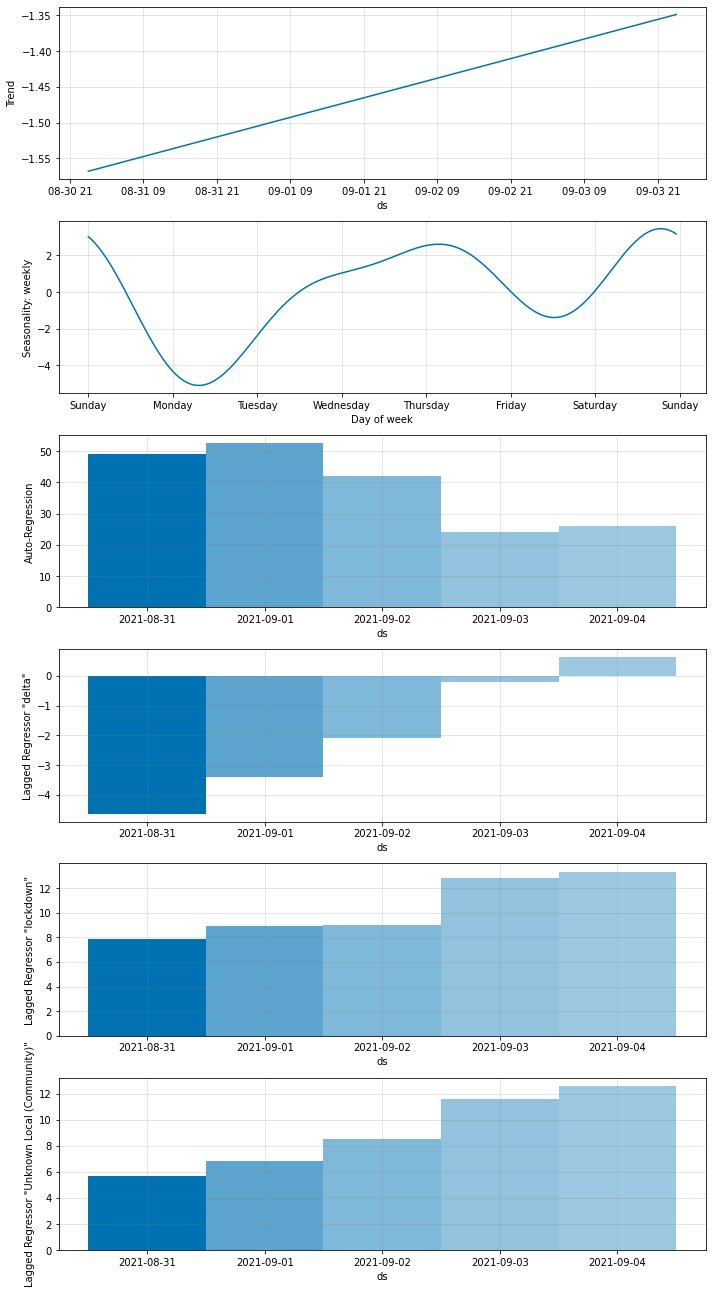

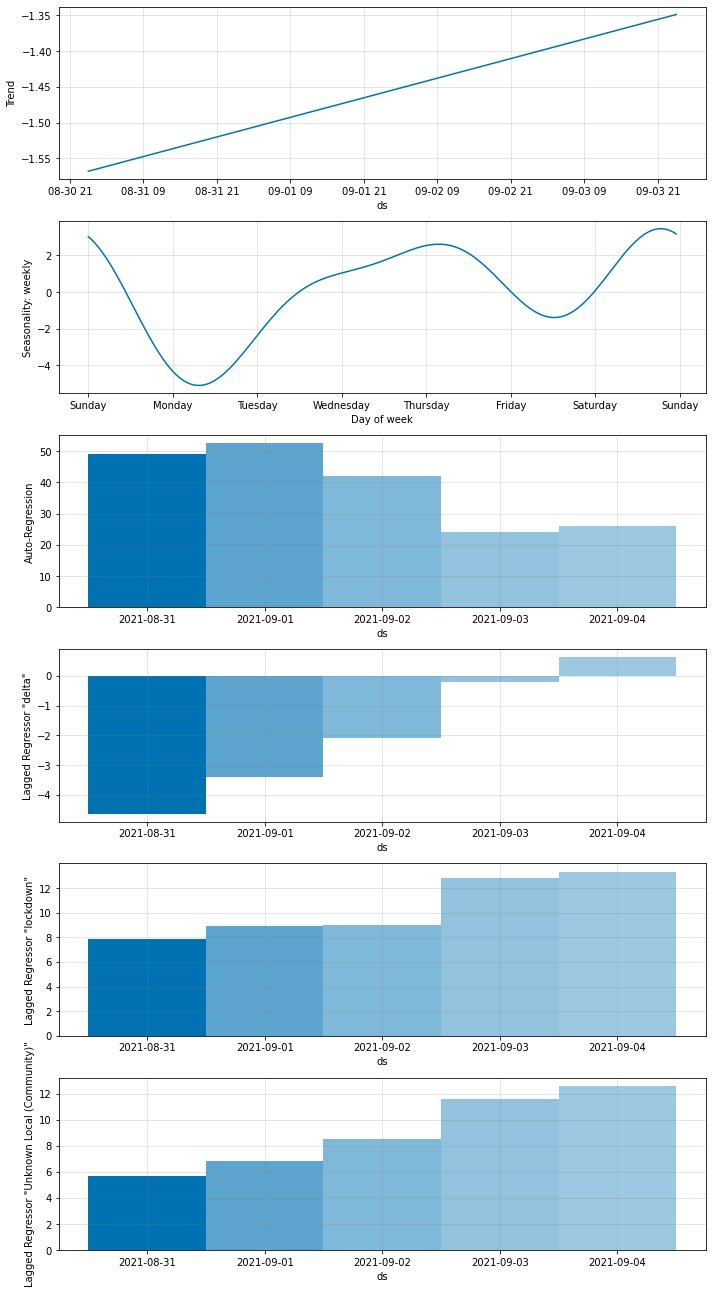

In [78]:
#Plotting the components
fb_neural_model.plot_components(fb_neural_forecast)

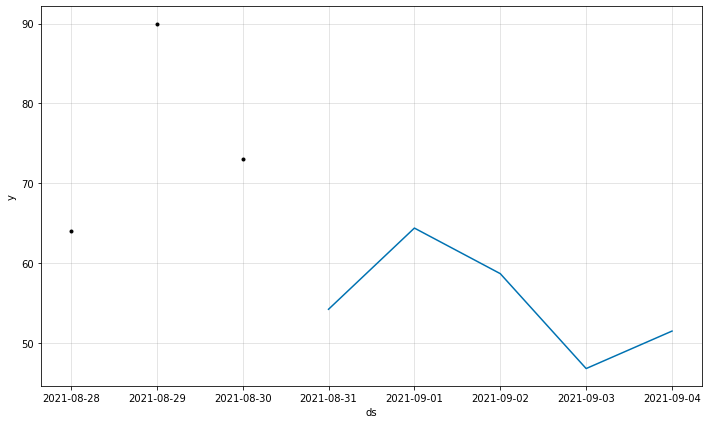

In [79]:
#Making the forecast plot
fb_neural_model.plot(fb_neural_forecast);

In [80]:
forecasts = []
for col in fb_neural_forecast.columns:
    if 'yhat' in col:
        forecasts.append([val for val in fb_neural_forecast[col] if val is not None][0])
forecast_df = fb_neural_forecast[["ds","y"]][-test.shape[0]:]
forecast_df.y = forecasts
forecast_df.set_index("ds", inplace=True)
forecast_df.head()

,y
ds,
2021-08-31,54.209999
2021-09-01,64.386086
2021-09-02,58.674721
2021-09-03,46.783604
2021-09-04,51.479687


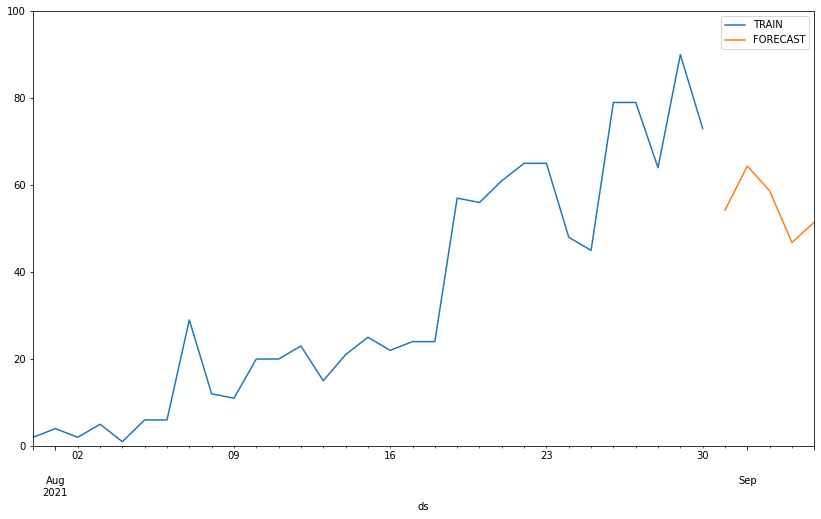

In [81]:
ax = vic_cases_wf_final["y"].plot(figsize=(14,8))
ax.plot(forecast_df["y"])
ax.set_xlim(date(2021,7,31), date(2021,9,4))
ax.set_ylim(0,100)
ax.legend(["TRAIN","FORECAST"]);

# 19 Are these any better than moving average models, why should we use or not use them? 